In [686]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt 
import seaborn as sns
import utils
import gensim
import sklearn
import keras

# the data 

In [3]:
df = utils.parse_csv("data/pocketbook-export.csv", "pocketbook")
df.head()

parsed file with pocketbook parser


,date,description,amount,category,subcategory,merchant,suburb,deal_with_later
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,Entertainment,Food,Gusto Italian,Restasuratthani,Thb000000236000
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,Utilities,Phone/Internet,Tpg Internet Pty Ltnorth,Ryde,Aud000000005999
2,2014-03-07,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,Web Hosting,None,Mtpmedia Temple,I8775784000,Usd000000005000
3,2014-04-07,Ebanking Transfer,665.00,Transferring Money,None,Ebanking Transfer,None,None
4,2014-04-07,Digitalocean Usd000000001000,-10.82,NaN,None,Digitalocean Usd000000001000,None,None


# word2vec

I'm going to use the merchant, suburb and amount to train a classifier to predict the category. So first of all we need to transfrom text into vectors. For that I'm using word2vec on googles pretrained word2vec

In [687]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('/Users/ko/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

now i need a set of unique words which are used in my data set. So first getting all the words from the description"

In [688]:
all_words = []
for sentence in df['merchant'].values.astype(str):
    for wrd in sentence.split(" "): 
        all_words.append(wrd.lower())
len(all_words)

9760

now making a set of them:

In [689]:
words_set = set(all_words)
len(words_set)

1556

and then my own dictionary:

In [690]:
word2vec = {}
for wrd in words_set:
    alpha_wrd = "".join([c for c in wrd if c.isalpha()])
    try:
        word2vec[wrd] = word_vectors.word_vec(alpha_wrd)
    except KeyError:
        word2vec[wrd] = np.zeros(300,)

        # deal with None values
word2vec[None] = np.zeros(300,)
word2vec[np.NaN] = np.zeros(300,)

word2vec["7eleven"].shape, word2vec[np.NaN].shape

((300,), (300,))

## now to convert the text col into vectors

first, to split the text column so there is one col per word

In [691]:
df = utils.parse_csv("data/pocketbook-export.csv", "pocketbook")
df.head()

parsed file with pocketbook parser


,date,description,amount,category,subcategory,merchant,suburb,deal_with_later
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,Entertainment,Food,Gusto Italian,Restasuratthani,Thb000000236000
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,Utilities,Phone/Internet,Tpg Internet Pty Ltnorth,Ryde,Aud000000005999
2,2014-03-07,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,Web Hosting,None,Mtpmedia Temple,I8775784000,Usd000000005000
3,2014-04-07,Ebanking Transfer,665.00,Transferring Money,None,Ebanking Transfer,None,None
4,2014-04-07,Digitalocean Usd000000001000,-10.82,NaN,None,Digitalocean Usd000000001000,None,None


so I'm only going to use the merchant col 

In [698]:
df['merchant'] = df.merchant.str.lower()
df2 = df['merchant'].str.split(" ", expand=True)
df2.head()

,0,1,2,3,4,5
0,gusto,italian,None,None,None,None
1,tpg,internet,pty,ltnorth,None,None
2,mtpmedia,temple,None,None,None,None
3,ebanking,transfer,None,None,None,None
4,digitalocean,usd000000001000,None,None,None,None


In [699]:
for col in df2:
    df2[col] = df2[col].apply(lambda x: word2vec[x])
df2.head()

,0,1,2,3,4,5
0,"[0.28125, 0.158203, 0.0383301, -0.00119781, 0....","[-0.0786133, -0.0400391, 0.271484, 0.229492, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0527344, 0.245117, 0.150391, 0.265625, -0.0...","[0.164062, -0.0825195, -0.120605, -0.0361328, ...","[-0.0195312, -0.0524902, -0.117676, -0.108887,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.318359, 0.115234, 0.170898, -0.0388184, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0078125, 0.0375977, -0.132812, 0.133789, 0....","[0.006073, 0.234375, -0.0446777, 0.0703125, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.224609, -0.257812, -0.373047, 0.414062, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## now to add in the amount and category col

In [700]:
df3 = df2.join(df[['amount',"category"]])
df3.head()

,0,1,2,3,4,5,amount,category
0,"[0.28125, 0.158203, 0.0383301, -0.00119781, 0....","[-0.0786133, -0.0400391, 0.271484, 0.229492, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-79.40,Entertainment
1,"[0.0527344, 0.245117, 0.150391, 0.265625, -0.0...","[0.164062, -0.0825195, -0.120605, -0.0361328, ...","[-0.0195312, -0.0524902, -0.117676, -0.108887,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-59.99,Utilities
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.318359, 0.115234, 0.170898, -0.0388184, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-54.03,Web Hosting
3,"[0.0078125, 0.0375977, -0.132812, 0.133789, 0....","[0.006073, 0.234375, -0.0446777, 0.0703125, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",665.00,Transferring Money
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.224609, -0.257812, -0.373047, 0.414062, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-10.82,NaN


## convert category labels into numbers

one way is to turn the categorys into numbers, though ideally we would onehot encode:

In [701]:
df3['category'] = df['category'].astype("category")

In [702]:
df3['cat'] = df3['category'].cat.codes
df3.head(3)

,0,1,2,3,4,5,amount,category,cat
0,"[0.28125, 0.158203, 0.0383301, -0.00119781, 0....","[-0.0786133, -0.0400391, 0.271484, 0.229492, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-79.40,Entertainment,7
1,"[0.0527344, 0.245117, 0.150391, 0.265625, -0.0...","[0.164062, -0.0825195, -0.120605, -0.0361328, ...","[-0.0195312, -0.0524902, -0.117676, -0.108887,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-59.99,Utilities,21
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.318359, 0.115234, 0.170898, -0.0388184, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-54.03,Web Hosting,22


now to make numpy arrays of the data

In [703]:
y_df = df3.cat
y_data = np.array(y_df.as_matrix(), dtype=int)
y_data.shape, y_data[:10]

((4270,), array([ 7, 21, 22, 19, -1, 20, 20,  6, 11, -1]))

y looks good, moving on to x and looking at only the first 3 columns, as very few descriptions have more than 3 words

In [704]:
x_df = df3.iloc[:,:3]
x_data = x_df.as_matrix()
x_data.shape

(4270, 3)

# now to actually train a classifier

In [705]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(x_data,y_data)

ValueError: setting an array element with a sequence.

checking to see if shapes are consistent in x

In [707]:
set([a[0].shape for a in x_data])

{(300,)}

## checking a simple classifer

x has 2 values which predict a y

In [473]:
x = np.array([[i+np.random.normal(-25,10), i+np.random.normal(0,15)] for i in range(100)])
y = np.array([i for i in range(100)])
x.shape, y.shape

((100, 2), (100,))

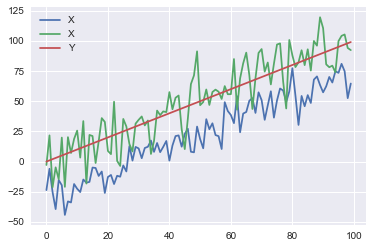

In [474]:
plt.plot(x, label="X")
plt.plot(y, label="Y")
plt.legend()

In [492]:
clf = sklearn.linear_model.LinearRegression()
clf.fit(x,y)
clf.score(x,y)

0.93177306203786847

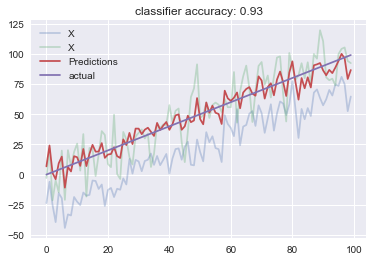

In [493]:
plt.title(f"classifier accuracy: {clf.score(x,y):.2f}")
plt.plot(x, label="X", alpha=0.3)
plt.plot(clf.predict(x), label="Predictions")
plt.plot(y, label="actual")
plt.legend();

# ok lets try keras

In [662]:
df3.dropna()
print(df3.shape)
df3.head(2)

(4270, 9)


,0,1,2,3,4,5,amount,category,cat
0,"[0.28125, 0.158203, 0.0383301, -0.00119781, 0....","[-0.0786133, -0.0400391, 0.271484, 0.229492, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-79.40,Entertainment,7
1,"[0.0527344, 0.245117, 0.150391, 0.265625, -0.0...","[0.164062, -0.0825195, -0.120605, -0.0361328, ...","[-0.0195312, -0.0524902, -0.117676, -0.108887,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-59.99,Utilities,21


In [670]:
x_train.shape, y_train.shape

((4270, 3), (4270,))

basic keras model

In [666]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4270, 3)))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [667]:
model.fit(x_train, y_train, epochs=5, batch_size=32)

ValueError: Error when checking input: expected dense_58_input to have 3 dimensions, but got array with shape (4270, 3)